In [1]:
import pyro
from pyro.infer import MCMC, NUTS, HMC
from functools import partial
import ot

In [2]:
import os, sys
cwd = os.getcwd()

api_path = os.path.join(cwd, '..', 'tools')
models_path = os.path.join(cwd, '..', 'models_25gaussians', 'jensen_minimax')
sys.path.append(api_path)

In [3]:
import numpy as np
import sklearn.datasets
import time
import random
import glob

from matplotlib import pyplot as plt

import torch, torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch import autograd
from torch.distributions import MultivariateNormal, Normal, Independent, Uniform

from utils import (Evolution,
                   prepare_25gaussian_data, 
                   prepare_swissroll_data,
                   prepare_gaussians,
                   prepare_train_batches,
                   prepare_dataloader,
                   logging)
from gan_fc_models import (Generator_fc, 
                           Discriminator_fc, 
                           weights_init_1, 
                           weights_init_2)
from gan_train import train_gan
from visualization import (send_file_to_remote,
                           sample_fake_data,
                           plot_fake_data_mode,
                           visualize_fake_data_projection,
                           discriminator_2d_visualization,
                           mh_sampling_visualize,
                           visualize_potential_energy,
                           langevin_sampling_visualize,
                           mala_sampling_visualize,
                           epoch_visualization)
from mh_2d_sampling import mh_sampling
from ebm_2d_sampling import (langevin_sampling, 
                             mala_sampling)

In [4]:
from sklearn.preprocessing import StandardScaler
random_seed = 42
train_dataset_size = 64000
sigma = 0.05

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

X_train, means = prepare_25gaussian_data(train_dataset_size,
                                         sigma, 
                                         random_seed)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

In [5]:
n_dim = 2
n_layers_g = 4
n_hid_g = 100
n_out = 2

n_layers_d = 4
n_hid_d = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

G = Generator_fc(n_dim=n_dim, 
                 n_layers=n_layers_g,
                 n_hid=n_hid_g,
                 n_out=n_out,
                 non_linear=nn.ReLU(),
                 device=device)
D = Discriminator_fc(n_in=n_dim, 
                     n_layers=n_layers_d,
                     n_hid=n_hid_d,
                     non_linear=nn.ReLU(),
                     device=device)

In [6]:
discriminator_regexp = os.path.join(models_path, "*_discriminator.pth")
generator_regexp = os.path.join(models_path, "*_generator.pth")
discriminator_name = [f for f in glob.glob(discriminator_regexp)][0]
generator_name = [f for f in glob.glob(generator_regexp)][0]

In [7]:
G.load_state_dict(torch.load(generator_name))
D.load_state_dict(torch.load(discriminator_name))

<All keys matched successfully>

In [8]:
epoch = 1000
path_to_save = None
batch_size_sample = 5000  

In [9]:
G = G.to(device)
D = D.to(device)

In [10]:
for p in D.parameters():  
    p.requires_grad = False
for p in G.parameters():  
    p.requires_grad = False

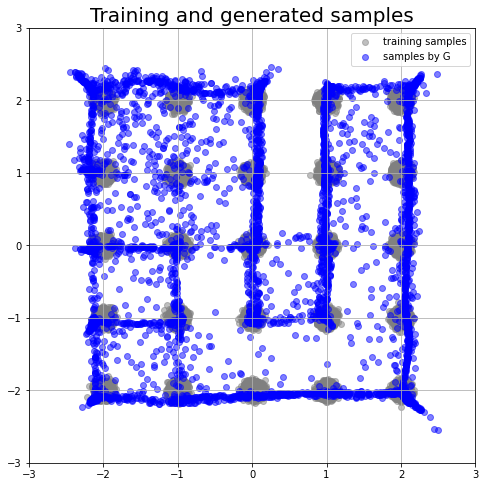

In [11]:
sample_fake_data(G, X_train, epoch, path_to_save, 
                 scaler = scaler,
                 batch_size_sample = batch_size_sample)

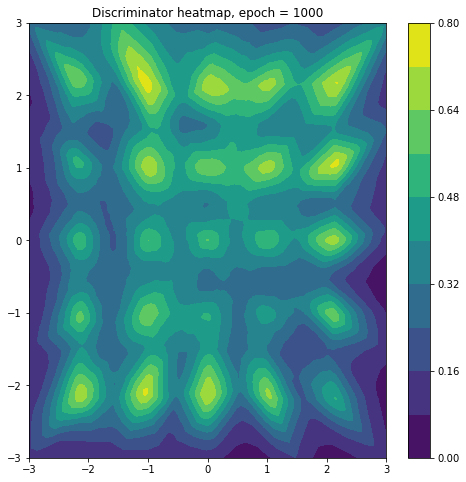

In [19]:
x_range = 3.0
y_range = 3.0
discriminator_2d_visualization(D,
                               x_range,
                               y_range,
                               path_to_save,
                               epoch,
                               scaler = scaler,
                               num_points = 700)

  0%|          | 0/5000 [00:00<?, ?it/s]

Start to do MH sampling....


100%|██████████| 5000/5000 [01:04<00:00, 77.52it/s]


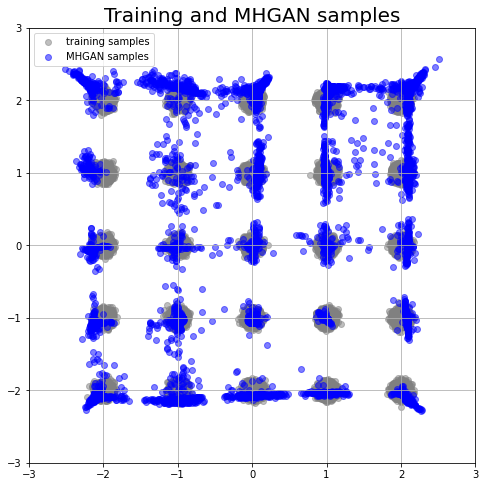

In [12]:
n_calib_pts = 10000
type_calibrator = 'iso'
normalize_to_0_1 = True
mh_sampling_visualize(G, 
                      D,
                      X_train, epoch, 
                      path_to_save,
                      n_calib_pts = n_calib_pts,
                      scaler = scaler, 
                      batch_size_sample = batch_size_sample,
                      type_calibrator = type_calibrator,
                      normalize_to_0_1 = normalize_to_0_1)

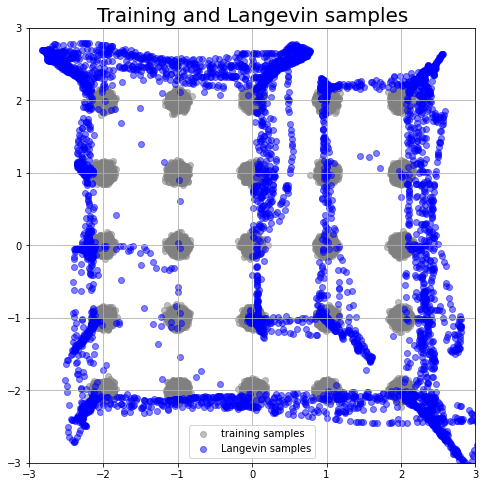

In [25]:
z_dim = G.n_dim
eps = 1e-3
num_iter = batch_size_sample
langevin_samples = Langevin_sampling(G, D, z_dim, eps, num_iter, device)
fake_langevin = G(langevin_samples).data.cpu().numpy()
mode = 'Langevin'
plot_fake_data_mode(fake_langevin, X_train, mode, path_to_save, 
                    scaler = scaler)

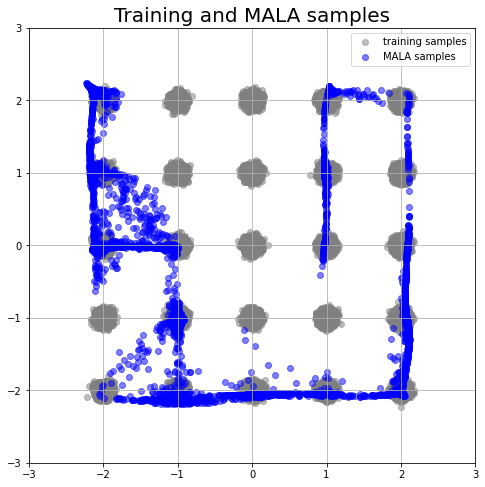

In [28]:
z_dim = G.n_dim
eps = 1e-3
num_iter = batch_size_sample
mala_samples = MALA_sampling(G, D, z_dim, eps, num_iter, device)
fake_mala = G(mala_samples).data.cpu().numpy()
mode = 'MALA'
plot_fake_data_mode(fake_mala, X_train, mode, path_to_save, 
                    scaler = scaler)

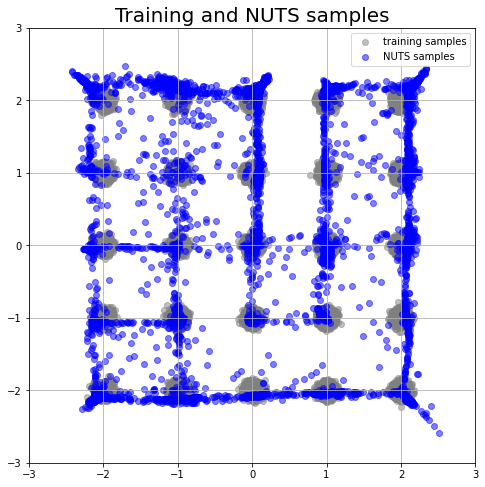

In [31]:
fake_nuts = G(nuts_samples[0]).data.cpu().numpy()
mode = 'NUTS'
plot_fake_data_mode(fake_nuts, X_train, mode, path_to_save, 
                    scaler = scaler)

100%|██████████| 1/1 [00:07<00:00,  7.75s/it]


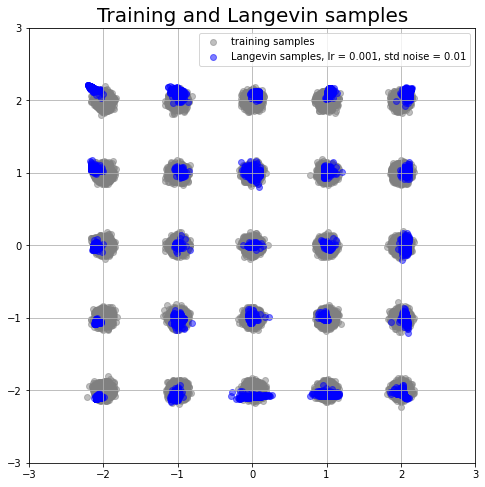

In [12]:
alpha = 1.0
step_lr = 1e-3
eps_std = 1e-2
n_steps = 5000
n_batches = 1
langevin_sampling_visualize(G, 
                            D,
                            X_train,  
                            path_to_save,
                            alpha = alpha,
                            scaler = scaler, 
                            batch_size_sample = batch_size_sample,
                            path_to_save_remote = None,
                            port_to_remote = None,
                            step_lr = step_lr,
                            eps_std = eps_std,
                            n_steps = n_steps,
                            n_batches = n_batches)

100%|██████████| 1/1 [00:41<00:00, 41.24s/it]


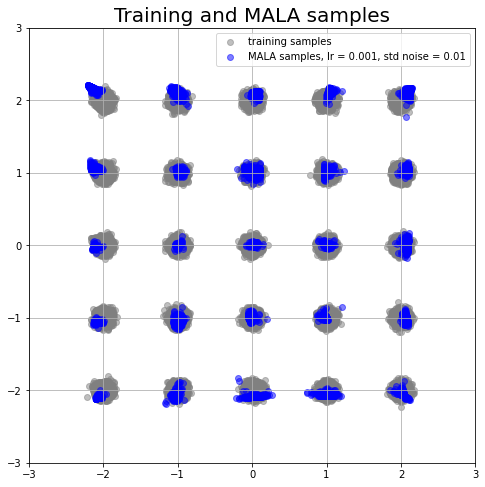

In [256]:
alpha = 1.0
step_lr = 1e-3
eps_std = 1e-2
n_steps = 5000
n_batches = 1
mala_sampling_visualize(G, 
                        D,
                        X_train,  
                        path_to_save,
                        alpha = alpha,
                        scaler = scaler, 
                        batch_size_sample = batch_size_sample,
                        path_to_save_remote = None,
                        port_to_remote = None,
                        step_lr = step_lr,
                        eps_std = eps_std,
                        n_steps = n_steps,
                        n_batches = n_batches)

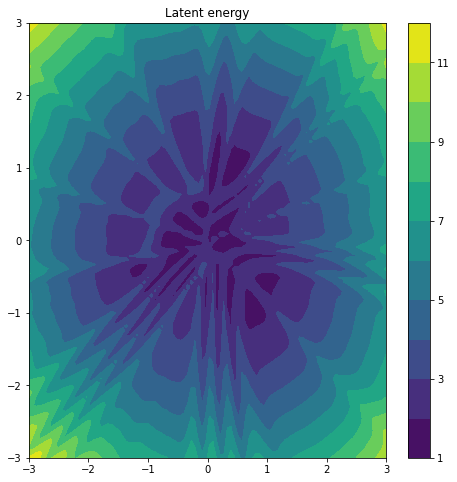

In [17]:
x_range = 3.0
y_range = 3.0
norm_grads = False
normalize_to_0_1 = True
path_to_save = None
visualize_potential_energy(D,
                           G,
                           x_range,
                           y_range,
                           path_to_save = path_to_save,
                           norm_grads = norm_grads,
                           normalize_to_0_1 = normalize_to_0_1,
                           num_points = 100)

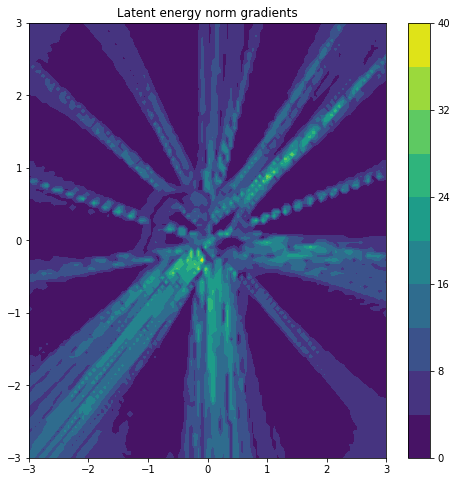

In [18]:
x_range = 3.0
y_range = 3.0
norm_grads = True
normalize_to_0_1 = True
visualize_potential_energy(D,
                           G,
                           x_range,
                           y_range,
                           norm_grads = norm_grads,
                           normalize_to_0_1 =normalize_to_0_1)

# X-Try MALA

In [28]:
weights = torch.tensor([[1, 10, 3, 1], [1, 2, 300, 10000]], dtype=torch.float)
a = torch.multinomial(weights, 1)
a

tensor([[1],
        [3]])

In [29]:
weights

tensor([[1.0000e+00, 1.0000e+01, 3.0000e+00, 1.0000e+00],
        [1.0000e+00, 2.0000e+00, 3.0000e+02, 1.0000e+04]])

In [47]:
batch_size = 10 
z_dim = 2
N = 3
loc = torch.zeros(z_dim)
scale = torch.ones(z_dim)
normal = Normal(loc, scale)
noise = normal.sample([N, batch_size])
indices = torch.LongTensor([0,1,2])
print(noise[0, 0])
print(noise[1, 1])
print(noise[2, 2])
indices = indices.unsqueeze(-1).repeat(1,z_dim).unsqueeze(1)
result = torch.gather(noise, 1, indices).squeeze()
print(result)

tensor([ 0.4482, -0.1830])
tensor([-1.7615,  0.5214])
tensor([0.7188, 0.1845])
tensor([[ 0.4482, -0.1830],
        [-1.7615,  0.5214],
        [ 0.7188,  0.1845]])


In [57]:
noise[:, [1], :].shape

torch.Size([3, 1, 2])

In [220]:
def e_grad(z, P, gen, dis, alpha, ret_e=False, e_batch=False):
    logp_z = torch.sum(P.log_prob(z), dim=1)
    x = gen(z)
    d = dis(x).view(-1)
    E_batch = (-logp_z - alpha * d)
    E = E_batch.sum()
    # E = - alpha * d
    E.backward()
    grad = z.grad
    # prior_grad = chainer.grad((-logp_z, ), (z, ))
    # d_grad = chainer.grad((d, ), (z, ))
    # import pdb
    # pdb.set_trace()
    if (ret_e and not e_batch):
        return E, grad
    elif (ret_e and e_batch):
        return E_batch, grad
    else:
        return grad

def compute_log_weight(first, second, gen, dis, P, alpha, step_lr, eps_std, clip = 50.0):
    #print(first.requires_grad)
    E_first, grad_first = e_grad(first, P, gen, dis, alpha, ret_e=True, e_batch = True)
        
    new_first = first - step_lr * grad_first
    #new_first = new_first.data
    
    E_second, grad_second = e_grad(second, P, gen, dis, alpha, ret_e=True, e_batch = True)
        
    new_second = second - step_lr * grad_second
    new_second = new_second.data
    
    log_energy = E_first - E_second
    vec_1 = (first - new_second)/eps_std
    vec_2 = (second - new_first)/eps_std
    #print(vec_1)
    #print(vec_2)
    
    propose_numerator = P.log_prob(vec_1).sum(dim=1)
    propose_denumerator = P.log_prob(vec_2).sum(dim=1)
    #print(propose_numerator)
    #print(propose_denumerator)

    log_propose_part = propose_numerator - propose_denumerator
    #print(log_propose_part)
    
    log_weight = log_energy + log_propose_part
    #log_weight = torch.clamp(log_weight, -clip, clip)
    #log_weight = log_weight - torch.max(log_weight, 0)[0]

    #weight = torch.exp(log_weight)
    #weight = weight/torch.sum(weight, 0)
    log_weight = log_weight.detach()
    
    return log_weight

In [211]:
z_dim = 2
batch_size = 5000
alpha = 1.0
step_lr = 1e-3
eps_std = 1e-2

loc = torch.zeros(z_dim).to(G.device)
scale = torch.ones(z_dim).to(G.device)
normal = Normal(loc, scale)
noise_1 = normal.sample([batch_size])
noise_2 = normal.sample([batch_size])
noise_1.requires_grad_(True)
noise_2.requires_grad_(True)
log_weight = compute_weight(noise_1, noise_2, G, D, normal, alpha, step_lr, eps_std)
log_weight

tensor([-179.9781,    5.2768,  -16.2779,  ...,  116.5184,    8.7695,
          -8.1686], device='cuda:0')

In [216]:
a = torch.tensor([[1., 2., 3.], [4., 5., 6.]])
b = a.max(dim = 1)[0]
print(b)

tensor([3., 6.])


In [219]:
b.unsqueeze(-1).repeat((1, 3))

tensor([[3., 3., 3.],
        [6., 6., 6.]])

In [235]:
def xtry_mala_dynamics(y0, y1, gen, dis, alpha, n_steps, step_lr, eps_std, N):
    y0_arr = [y0.detach().clone()]
    y1_arr = [y1.detach().clone()]
    batch_size, z_dim = y0.shape[0], y0.shape[1]
    loc = torch.zeros(z_dim).to(gen.device)
    scale = torch.ones(z_dim).to(gen.device)
    normal = Normal(loc, scale)

    for _ in range(n_steps):
        #print(f"step = {_}")
        U = np.random.randint(N)
        Z0 = y0.unsqueeze(1).repeat(1, N, 1)
        Z1 = y1.unsqueeze(1).repeat(1, N, 1)
        noise = normal.sample([batch_size, N])
        
        E_g_j, grad_g_j = e_grad(y0, normal, gen, dis, alpha, ret_e=True)
        g_j = y0 - step_lr * grad_g_j
        g_j = g_j.data
        
        g_j_N = g_j.unsqueeze(1).repeat(1, N, 1)
        Z1 = g_j_N + eps_std*noise
        Z1[:, U, :] = y1
        
        Z0_batch = Z0.view((batch_size*N, z_dim)).detach().clone()
        Z1_batch = Z1.view((batch_size*N, z_dim)).detach().clone()
        Z0_batch.requires_grad_(True)
        Z1_batch.requires_grad_(True)
        #print(Z0_batch.requires_grad)
        #print(Z1_batch.requires_grad)
        
        log_weight = compute_log_weight(Z0_batch, Z1_batch, gen, dis, normal, alpha, step_lr, eps_std)
        log_weight = log_weight.view((batch_size, N))
        #print(log_weight)
        max_logs = torch.max(log_weight, dim = 1)[0].unsqueeze(-1).repeat((1, N))
        log_weight = log_weight - max_logs
        weight = torch.exp(log_weight)
        sum_weight = torch.sum(weight, dim = 1).unsqueeze(-1).repeat((1, N))
        
        weight = weight/sum_weight
        #print(weight)
        
        indices = torch.multinomial(weight, 1)
        indices = indices.repeat(1, z_dim).unsqueeze(1)
        with torch.no_grad():
            y1 = torch.gather(Z1, 1, indices).squeeze()
            y1 = y1.data
            #print(z)
        y1.requires_grad_(True)
        y1_arr.append(y1.detach().clone())
            
        E_y1, grad_y1 = e_grad(y1, normal, gen, dis, alpha, ret_e=True)
        y0 = y1 - step_lr * grad_y1 + eps_std*noise[:, U, :]
        y0 = y0.data
        y0.requires_grad_(True)
        y0_arr.append(y0.detach().clone())
        
    return y0_arr, y1_arr

In [236]:
for p in D.parameters():  
    p.requires_grad = False
for p in G.parameters():  
    p.requires_grad = False

In [251]:
batchsize = 5000
alpha = 1.0
step_lr = 1e-3
eps_std = 1e-2
n_steps = 500
y0 = G.make_hidden(batchsize)
y0.requires_grad_(True)
y1 = G.make_hidden(batchsize)
y1.requires_grad_(True)
N = 2

y0_arr, y1_arr = xtry_mala_dynamics(y0, y1, G, D, alpha, n_steps, step_lr, eps_std, N)

In [249]:
y0_arr[0]

tensor([[-0.1082, -0.5230],
        [-1.0291,  0.6283],
        [ 1.8939,  0.7848],
        ...,
        [-0.4791,  0.1409],
        [ 0.7287,  0.4850],
        [-1.1250, -0.4316]], device='cuda:0')

In [250]:
y0_arr[1]

tensor([[-0.0971, -0.5367],
        [-1.0448,  0.6217],
        [ 1.9094,  0.8000],
        ...,
        [ 0.4675,  0.9890],
        [-2.5035, -0.5393],
        [-1.0996, -0.4234]], device='cuda:0')

In [245]:
y0_last = y0_arr[-1].to(G.device)
y1_last = y1_arr[-1].to(G.device)

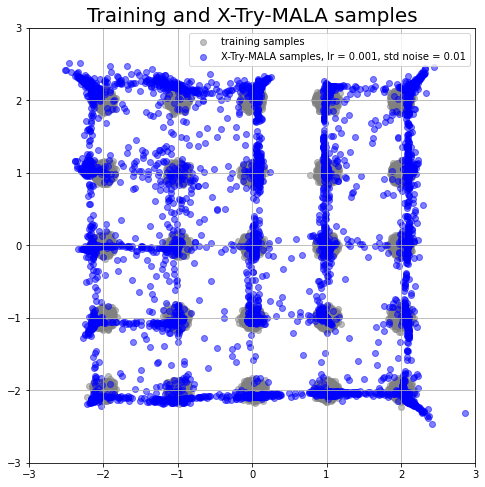

In [246]:
x_try_mala = G(y0_last).data.cpu().numpy()
mode = 'X-Try-MALA'
params = f'lr = {step_lr}, std noise = {eps_std}'
plot_fake_data_mode(x_try_mala, X_train, mode, path_to_save, 
                    scaler = scaler,
                    params = params)

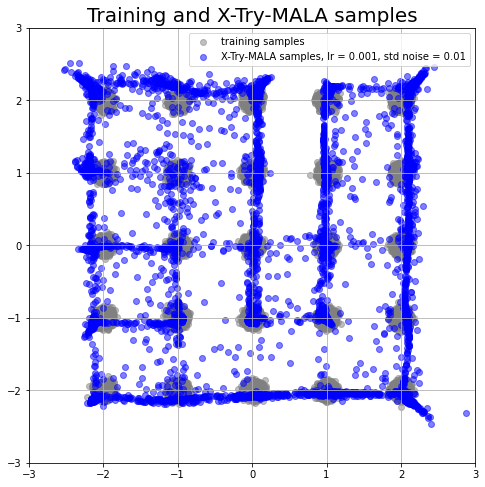

In [247]:
x_try_mala = G(y1_last).data.cpu().numpy()
mode = 'X-Try-MALA'
params = f'lr = {step_lr}, std noise = {eps_std}'
plot_fake_data_mode(x_try_mala, X_train, mode, path_to_save, 
                    scaler = scaler,
                    params = params)

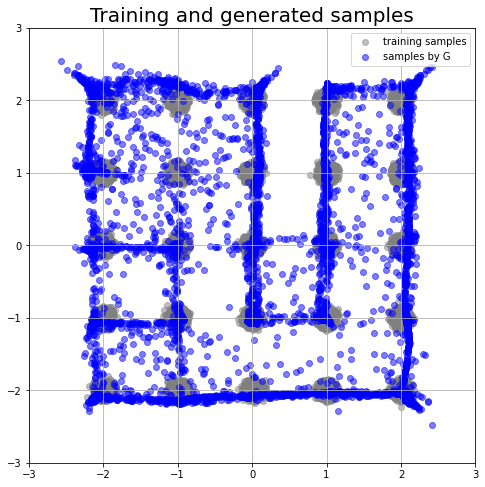

In [162]:
sample_fake_data(G, X_train, epoch, path_to_save, 
                 scaler = scaler,
                 batch_size_sample = batch_size_sample)

# MALA

In [12]:
for p in D.parameters():  
    p.requires_grad = False
for p in G.parameters():  
    p.requires_grad = False

In [73]:
batchsize = 5000
alpha = 1.0
step_lr = 1e-3
eps_std = 1e-2
n_steps = 5000
z = G.make_hidden(batchsize)
z.requires_grad_(True)
z_sp, acceptence = mala_dynamics(z, G, D, alpha, n_steps, step_lr, eps_std)

In [74]:
acceptence.mean()/n_steps

tensor(0.6859, device='cuda:0')

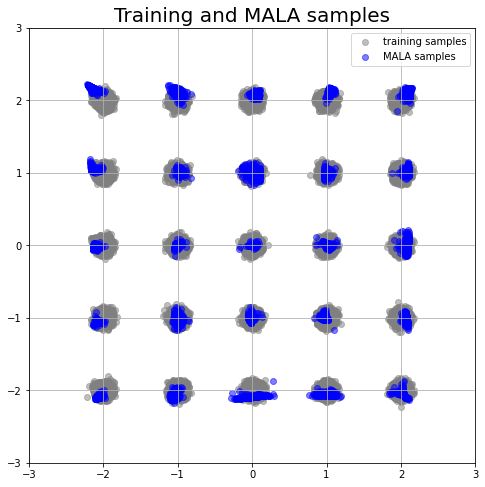

In [75]:
mala_samples = z_sp[-1]
fake_mala = G(mala_samples).data.cpu().numpy()
mode = 'MALA'
plot_fake_data_mode(fake_mala, X_train, mode, path_to_save, 
                    scaler = scaler)

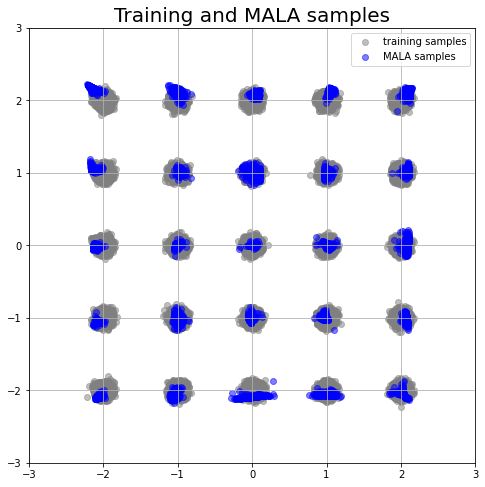

In [76]:
mask_new_samples = (z_copy != z_sp[-1])
new_samples = z_sp[-1][mask_new_samples]
num_samples = new_samples.shape[0] // 2
fake_mala = G(new_samples.view((num_samples, 2))).data.cpu().numpy()
mode = 'MALA'
plot_fake_data_mode(fake_mala, X_train, mode, path_to_save, 
                    scaler = scaler)

In [69]:
batchsize = 5000
alpha = 1.0
step_lr = 1e-2
eps_std = 1e-2
n_steps = 5000
z = G.make_hidden(batchsize)
z_copy = z.clone().detach()
z.requires_grad_(True)
z_sp, acceptence = mala_dynamics(z, G, D, alpha, n_steps, step_lr, eps_std)
print(acceptence.mean().data/n_steps)

tensor(0.0108, device='cuda:0')


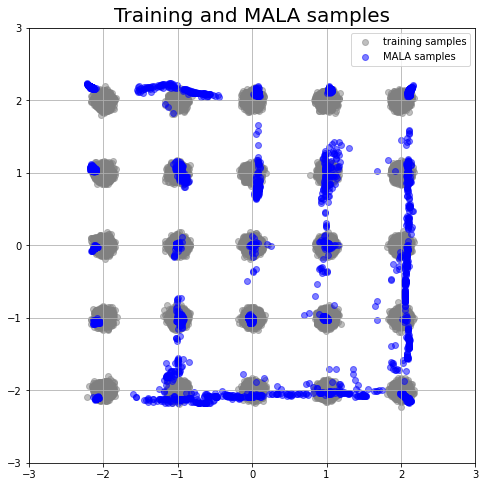

In [70]:
mala_samples = z_sp[-1]
fake_mala = G(mala_samples).data.cpu().numpy()
mode = 'MALA'
plot_fake_data_mode(fake_mala, X_train, mode, path_to_save, 
                    scaler = scaler)

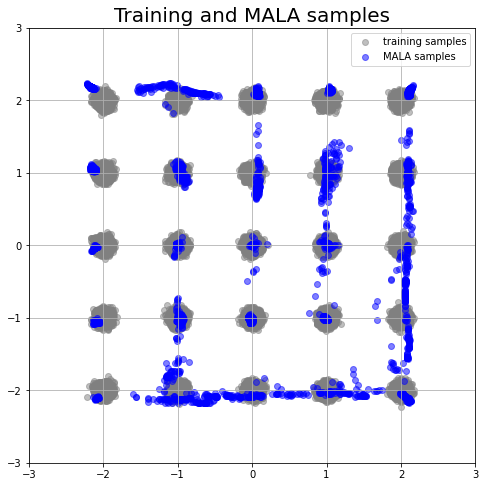

In [71]:
mask_new_samples = (z_copy != z_sp[-1])
new_samples = z_sp[-1][mask_new_samples]
num_samples = new_samples.shape[0] // 2
fake_mala = G(new_samples.view((num_samples, 2))).data.cpu().numpy()
mode = 'MALA'
plot_fake_data_mode(fake_mala, X_train, mode, path_to_save, 
                    scaler = scaler)

In [64]:
batchsize = 5000
alpha = 1.0
step_lr = 1e-3
eps_std = 1e-3
n_steps = 5000
z = G.make_hidden(batchsize)
z_copy = z.clone().detach()
z.requires_grad_(True)
z_sp, acceptence = mala_dynamics(z, G, D, alpha, n_steps, step_lr, eps_std)
print(acceptence.mean().data/n_steps)

tensor(0.8191, device='cuda:0')


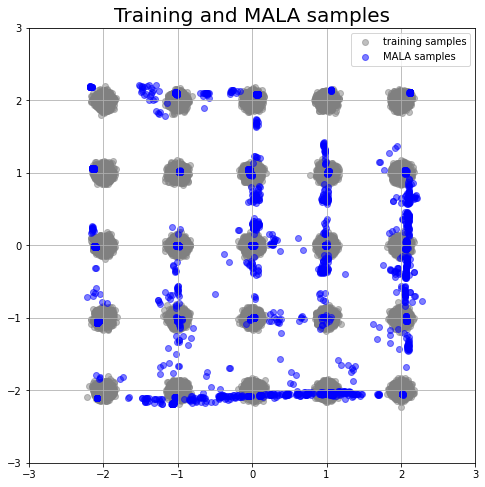

In [67]:
mala_samples = z_sp[-1]
fake_mala = G(mala_samples).data.cpu().numpy()
mode = 'MALA'
plot_fake_data_mode(fake_mala, X_train, mode, path_to_save, 
                    scaler = scaler)

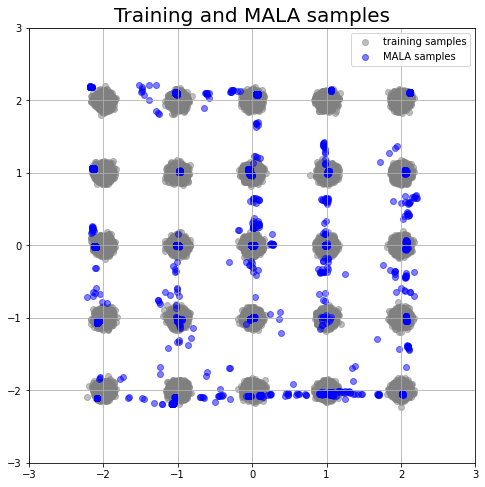

In [65]:
mask_new_samples = (z_copy != z_sp[-1])
new_samples = z_sp[-1][mask_new_samples]
num_samples = new_samples.shape[0] // 2
fake_mala = G(new_samples.view((num_samples, 2))).data.cpu().numpy()
mode = 'MALA'
plot_fake_data_mode(fake_mala, X_train, mode, path_to_save, 
                    scaler = scaler)

In [32]:
batchsize = 5000
alpha = 1.0
step_lr = 1e-1
eps_std = 1e-3
n_steps = 5000
z = G.make_hidden(batchsize)
z_copy = z.clone().detach()
z.requires_grad_(True)
z_sp, acceptence = mala_dynamics(z, G, D, alpha, n_steps, step_lr, eps_std)
print(acceptence.mean().data/n_steps)

tensor(4.0000e-08, device='cuda:0')


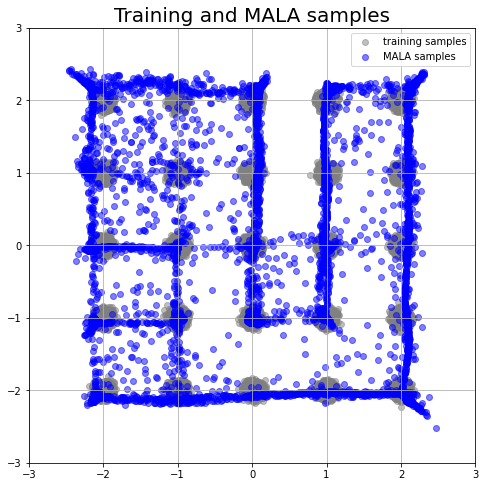

In [35]:
mala_samples = z_sp[-1]
fake_mala = G(mala_samples).data.cpu().numpy()
mode = 'MALA'
plot_fake_data_mode(fake_mala, X_train, mode, path_to_save, 
                    scaler = scaler)

In [37]:
mask_new_samples = (z_copy != z_sp[-1])
new_samples = z_sp[-1][mask_new_samples]
print(new_samples.shape)

torch.Size([2])


In [38]:
new_samples

tensor([0.5974, 1.1048], device='cuda:0')

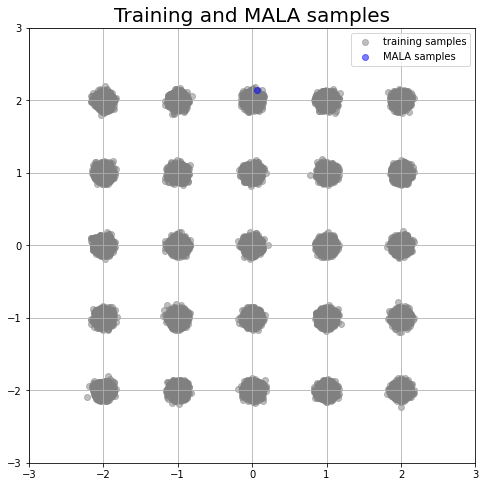

In [40]:
fake_mala = G(new_samples.view((1, 2))).data.cpu().numpy()
mode = 'MALA'
plot_fake_data_mode(fake_mala, X_train, mode, path_to_save, 
                    scaler = scaler)

In [41]:
batchsize = 5000
alpha = 1.0
step_lr = 1e-1
eps_std = 1e-2
n_steps = 5000
z = G.make_hidden(batchsize)
z_copy = z.clone().detach()
z.requires_grad_(True)
z_sp, acceptence = mala_dynamics(z, G, D, alpha, n_steps, step_lr, eps_std)
print(acceptence.mean().data/n_steps)

tensor(8.0000e-08, device='cuda:0')


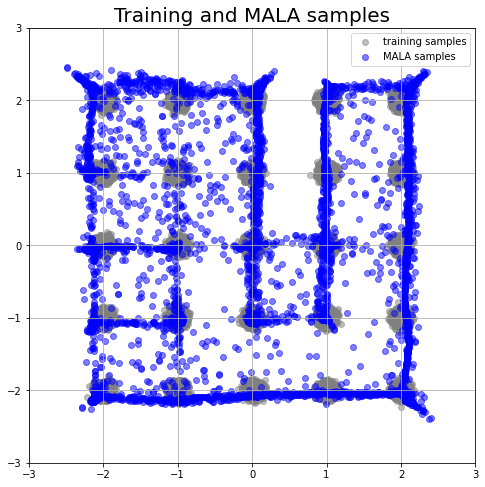

In [42]:
mala_samples = z_sp[-1]
fake_mala = G(mala_samples).data.cpu().numpy()
mode = 'MALA'
plot_fake_data_mode(fake_mala, X_train, mode, path_to_save, 
                    scaler = scaler)

In [46]:
mask_new_samples

tensor([[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]], device='cuda:0')

In [47]:
z_sp[-1]

tensor([[-3.1241,  1.6574],
        [ 0.4826, -0.1967],
        [ 1.6863,  0.8296],
        ...,
        [ 1.0031, -0.5051],
        [ 0.5871, -0.8596],
        [ 1.2122,  0.5603]], device='cuda:0')

In [48]:
new_samples

tensor([ 0.9699,  2.0739,  0.4184, -1.5051], device='cuda:0')

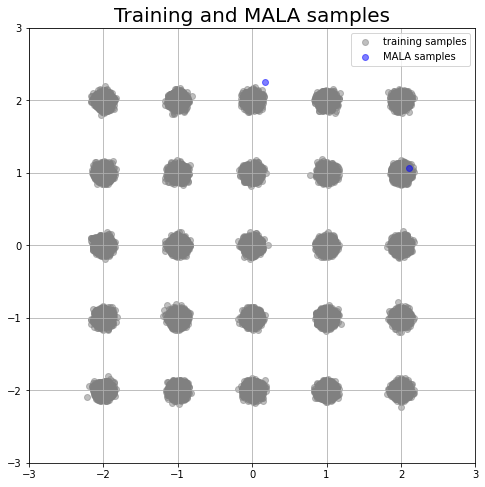

In [50]:
mask_new_samples = (z_copy != z_sp[-1])
new_samples = z_sp[-1][mask_new_samples]
num_samples = new_samples.shape[0] // 2
fake_mala = G(new_samples.view((num_samples, 2))).data.cpu().numpy()
mode = 'MALA'
plot_fake_data_mode(fake_mala, X_train, mode, path_to_save, 
                    scaler = scaler)

In [51]:
batchsize = 5000
alpha = 1.0
step_lr = 1e-2
eps_std = 1e-4
n_steps = 5000
z = G.make_hidden(batchsize)
z_copy = z.clone().detach()
z.requires_grad_(True)
z_sp, acceptence = mala_dynamics(z, G, D, alpha, n_steps, step_lr, eps_std)
print(acceptence.mean().data/n_steps)

tensor(0.0004, device='cuda:0')


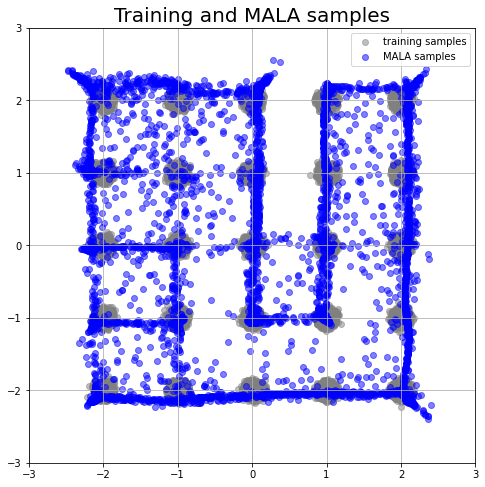

In [52]:
mala_samples = z_sp[-1]
fake_mala = G(mala_samples).data.cpu().numpy()
mode = 'MALA'
plot_fake_data_mode(fake_mala, X_train, mode, path_to_save, 
                    scaler = scaler)

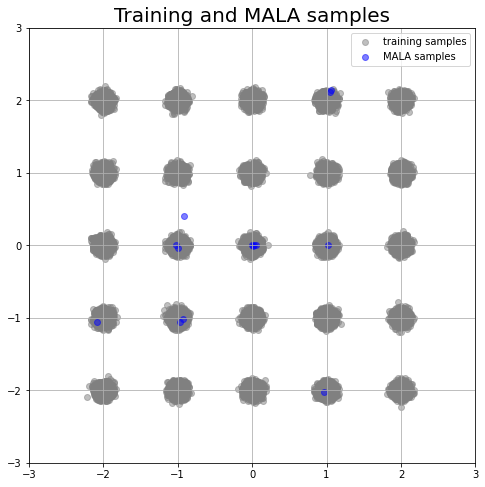

In [53]:
mask_new_samples = (z_copy != z_sp[-1])
new_samples = z_sp[-1][mask_new_samples]
num_samples = new_samples.shape[0] // 2
fake_mala = G(new_samples.view((num_samples, 2))).data.cpu().numpy()
mode = 'MALA'
plot_fake_data_mode(fake_mala, X_train, mode, path_to_save, 
                    scaler = scaler)

# NUTS

In [60]:
def calculate_energy(params, generator, discriminator, P, normalize_to_0_1, is_dict):
    if is_dict:
        params = params['points']
    generator_points = generator(params)
    if normalize_to_0_1:
        GAN_part = -discriminator(generator_points).view(-1)
    else:
        sigmoid_GAN_part = discriminator(generator_points)
        GAN_part = -(torch.log(sigmoid_GAN_part) - \
                     torch.log1p(-sigmoid_GAN_part)).view(-1)

    prior_part = -torch.sum(P.log_prob(params), dim=-1)
    return GAN_part + prior_part

In [61]:
n_dim = 2
n_layers_g = 4
n_hid_g = 100
n_out = 2

n_layers_d = 4
n_hid_d = 100

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

G = Generator_fc(n_dim=n_dim, 
                 n_layers=n_layers_g,
                 n_hid=n_hid_g,
                 n_out=n_out,
                 non_linear=nn.ReLU(),
                 device=device)
D = Discriminator_fc(n_in=n_dim, 
                     n_layers=n_layers_d,
                     n_hid=n_hid_d,
                     non_linear=nn.ReLU(),
                     device=device)

discriminator_regexp = os.path.join(models_path, "*_discriminator.pth")
generator_regexp = os.path.join(models_path, "*_generator.pth")
discriminator_name = [f for f in glob.glob(discriminator_regexp)][0]
generator_name = [f for f in glob.glob(generator_regexp)][0]

G.load_state_dict(torch.load(generator_name))
D.load_state_dict(torch.load(discriminator_name))

G = G.to(device)
D = D.to(device)

for p in D.parameters():  
    p.requires_grad = False
for p in G.parameters():  
    p.requires_grad = False

In [62]:
n_dim = G.n_dim
loc = torch.zeros(n_dim).to(G.device)
scale = torch.ones(n_dim).to(D.device)
normal = Normal(loc, scale)

normalize_to_0_1 = True
is_dict = True

cur_calculate_energy = partial(calculate_energy, 
                               generator = G,
                               discriminator = D,
                               P = normal,
                               normalize_to_0_1 = normalize_to_0_1,
                               is_dict = is_dict)

In [63]:
kernel = NUTS(potential_fn = cur_calculate_energy)

In [64]:
num_samples = 10
batchsize = 2

init_params = G.make_hidden(batchsize).to(device)
init_params = {'points': init_params}

In [65]:
cur_calculate_energy(init_params)

tensor([2.7370, 3.3742])

In [66]:
mcmc = MCMC(kernel = kernel, 
            num_samples = num_samples, 
            initial_params = init_params,
            num_chains = batchsize)

Warmup [1]:   0%|          | 0/20 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/20 [00:00, ?it/s]

In [67]:
mcmc.run()

[ERROR LOG CHAIN:0]Unable to handle autograd's threading in combination with fork-based multiprocessing. See https://github.com/pytorch/pytorch/wiki/Autograd-and-Fork
Traceback (most recent call last):
  File "/usr/lib/python3.9/site-packages/pyro/infer/mcmc/api.py", line 96, in run
    for sample in _gen_samples(self.kernel, self.warmup_steps, self.num_samples, logging_hook,
  File "/usr/lib/python3.9/site-packages/pyro/infer/mcmc/api.py", line 108, in _gen_samples
    kernel.setup(warmup_steps, *args, **kwargs)
  File "/usr/lib/python3.9/site-packages/pyro/infer/mcmc/hmc.py", line 306, in setup
    z_grads, potential_energy = potential_grad(self.potential_fn, z)
  File "/usr/lib/python3.9/site-packages/pyro/ops/integrator.py", line 84, in potential_grad
    grads = grad(potential_energy, z_nodes)
  File "/usr/lib/python3.9/site-packages/torch/autograd/__init__.py", line 202, in grad
    return Variable._execution_engine.run_backward(
RuntimeError: Unable to handle autograd's threadin

[ERROR LOG CHAIN:0]Unable to handle autograd's threading in combination with fork-based multiprocessing. See https://github.com/pytorch/pytorch/wiki/Autograd-and-Fork
Traceback (most recent call last):
  File "/usr/lib/python3.9/site-packages/pyro/infer/mcmc/api.py", line 96, in run
    for sample in _gen_samples(self.kernel, self.warmup_steps, self.num_samples, logging_hook,
  File "/usr/lib/python3.9/site-packages/pyro/infer/mcmc/api.py", line 108, in _gen_samples
    kernel.setup(warmup_steps, *args, **kwargs)
  File "/usr/lib/python3.9/site-packages/pyro/infer/mcmc/hmc.py", line 306, in setup
    z_grads, potential_energy = potential_grad(self.potential_fn, z)
  File "/usr/lib/python3.9/site-packages/pyro/ops/integrator.py", line 84, in potential_grad
    grads = grad(potential_energy, z_nodes)
  File "/usr/lib/python3.9/site-packages/torch/autograd/__init__.py", line 202, in grad
    return Variable._execution_engine.run_backward(
RuntimeError: Unable to handle autograd's threadin

RuntimeError: Unable to handle autograd's threading in combination with fork-based multiprocessing. See https://github.com/pytorch/pytorch/wiki/Autograd-and-Fork

In [24]:
device = 'cpu'
target = torch.distributions.Normal(loc=torch.tensor([10., 10.], device=device, dtype=torch.float32),
                                    scale=torch.tensor([1., 1.], device=device, dtype=torch.float32))

In [25]:
def potential_fn(samples):
    return -target.log_prob(samples['points']).sum(-1)

In [26]:
nuts = NUTS(potential_fn=potential_fn)

In [27]:
num_chains = 6
initial_params = {'points': torch.randn((num_chains, 2), dtype=torch.float32, device=device)}

In [52]:
potential_fn(initial_params)

tensor([ 89.7230,  88.2194,  87.5004,  99.5866, 120.7469, 113.0349])

In [28]:
mcmc = MCMC(kernel=nuts, num_samples=100, warmup_steps=100,
            initial_params=initial_params, num_chains=num_chains)

Warmup [1]:   0%|          | 0/200 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/200 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/200 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/200 [00:00, ?it/s]

Warmup [5]:   0%|          | 0/200 [00:00, ?it/s]

Warmup [6]:   0%|          | 0/200 [00:00, ?it/s]

In [29]:
mcmc.run()

[ERROR LOG CHAIN:0]Unable to handle autograd's threading in combination with fork-based multiprocessing. See https://github.com/pytorch/pytorch/wiki/Autograd-and-Fork
Traceback (most recent call last):
  File "/usr/lib/python3.9/site-packages/pyro/infer/mcmc/api.py", line 96, in run
    for sample in _gen_samples(self.kernel, self.warmup_steps, self.num_samples, logging_hook,
  File "/usr/lib/python3.9/site-packages/pyro/infer/mcmc/api.py", line 108, in _gen_samples
    kernel.setup(warmup_steps, *args, **kwargs)
  File "/usr/lib/python3.9/site-packages/pyro/infer/mcmc/hmc.py", line 306, in setup
    z_grads, potential_energy = potential_grad(self.potential_fn, z)
  File "/usr/lib/python3.9/site-packages/pyro/ops/integrator.py", line 84, in potential_grad
    grads = grad(potential_energy, z_nodes)
  File "/usr/lib/python3.9/site-packages/torch/autograd/__init__.py", line 202, in grad
    return Variable._execution_engine.run_backward(
RuntimeError: Unable to handle autograd's threadin

[ERROR LOG CHAIN:2]Unable to handle autograd's threading in combination with fork-based multiprocessing. See https://github.com/pytorch/pytorch/wiki/Autograd-and-Fork
Traceback (most recent call last):
  File "/usr/lib/python3.9/site-packages/pyro/infer/mcmc/api.py", line 96, in run
    for sample in _gen_samples(self.kernel, self.warmup_steps, self.num_samples, logging_hook,
  File "/usr/lib/python3.9/site-packages/pyro/infer/mcmc/api.py", line 108, in _gen_samples
    kernel.setup(warmup_steps, *args, **kwargs)
  File "/usr/lib/python3.9/site-packages/pyro/infer/mcmc/hmc.py", line 306, in setup
    z_grads, potential_energy = potential_grad(self.potential_fn, z)
  File "/usr/lib/python3.9/site-packages/pyro/ops/integrator.py", line 84, in potential_grad
    grads = grad(potential_energy, z_nodes)
  File "/usr/lib/python3.9/site-packages/torch/autograd/__init__.py", line 202, in grad
    return Variable._execution_engine.run_backward(
RuntimeError: Unable to handle autograd's threadin

[ERROR LOG CHAIN:3]Unable to handle autograd's threading in combination with fork-based multiprocessing. See https://github.com/pytorch/pytorch/wiki/Autograd-and-Fork
Traceback (most recent call last):
  File "/usr/lib/python3.9/site-packages/pyro/infer/mcmc/api.py", line 96, in run
    for sample in _gen_samples(self.kernel, self.warmup_steps, self.num_samples, logging_hook,
  File "/usr/lib/python3.9/site-packages/pyro/infer/mcmc/api.py", line 108, in _gen_samples
    kernel.setup(warmup_steps, *args, **kwargs)
  File "/usr/lib/python3.9/site-packages/pyro/infer/mcmc/hmc.py", line 306, in setup
    z_grads, potential_energy = potential_grad(self.potential_fn, z)
  File "/usr/lib/python3.9/site-packages/pyro/ops/integrator.py", line 84, in potential_grad
    grads = grad(potential_energy, z_nodes)
  File "/usr/lib/python3.9/site-packages/torch/autograd/__init__.py", line 202, in grad
    return Variable._execution_engine.run_backward(
RuntimeError: Unable to handle autograd's threadin

RuntimeError: Unable to handle autograd's threading in combination with fork-based multiprocessing. See https://github.com/pytorch/pytorch/wiki/Autograd-and-Fork